This notebook looks at shared kmer (hash) content for the full query genomes. 
This is NOT the metric I ended up going with -- because these bugs are more deeply sequenced in CD, they end up with many more k-mers. 
What we really care about is for k-mers that _are_ more abundant, do they sometimes occur in nonIBD/UC, or are they exclusive to CD?

In [1]:
setwd("..")

In [3]:
library(pagoo)
library(readr)
library(tidyr)
library(ggplot2)
library(aplot)
library(dplyr)
library(UpSetR)
library(pheatmap)
library(RColorBrewer)

### metadata

In [5]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct()

### work with sketch table long

In [8]:
species_string <- "GCF_008121495.1--s__Ruminococcus_B_gnavus"
species_string1 <- species_string
species_string2 <- gsub("-", ".", species_string1)
species_string3 <- gsub(".*s__", "", species_string2)
species_string3 <- gsub("_", " ", species_string3)
species_string4 <- gsub(".*\\.", "", species_string2)
species_string4 <- gsub("(.*__.*?)_(.*?)", "\\1 \\2 ", species_string4)
species_string4 <- gsub("  ", " ", species_string4)

In [10]:
path <- paste0("outputs/sgc_genome_queries_orpheum_species_sketch_table/", species_string1, "_long.csv")
sketch_table <- read_csv(path)
acc_df <- data.frame(acc = unique(sketch_table$acc))
acc_df <- acc_df %>%
  mutate(library_name = gsub(paste0(".", species_string2), "", acc),
         library_name = gsub("\\.01", "-01", library_name),
         library_name = gsub("\\.02", "-02", library_name),
         library_name = gsub("bgi\\.", "bgi-", library_name),
         library_name = gsub("UC\\.", "UC-", library_name),
         library_name = gsub("CD\\.", "CD-", library_name),
         library_name = gsub("Pond\\.", "Pond-", library_name)) %>%
  mutate(species = gsub(".*\\.\\.", "", acc)) %>%
  left_join(metadata, by = "library_name")

Rows: 3226450 Columns: 3
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): acc
dbl (2): minhash, present

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
sketch_table <- left_join(sketch_table, acc_df, by = "acc")         

In [12]:
# how many hashes are observed?
length(unique(sketch_table$minhash))

[1] 512215

In [13]:
# how many hashes are observed for each diagnosis?
tmp <- sketch_table %>%
  group_by(diagnosis) %>%
  select(minhash, diagnosis) %>%
  distinct() %>%
  tally()
tmp

diagnosis,n
<chr>,<int>
CD,307713
nonIBD,173751
UC,188430


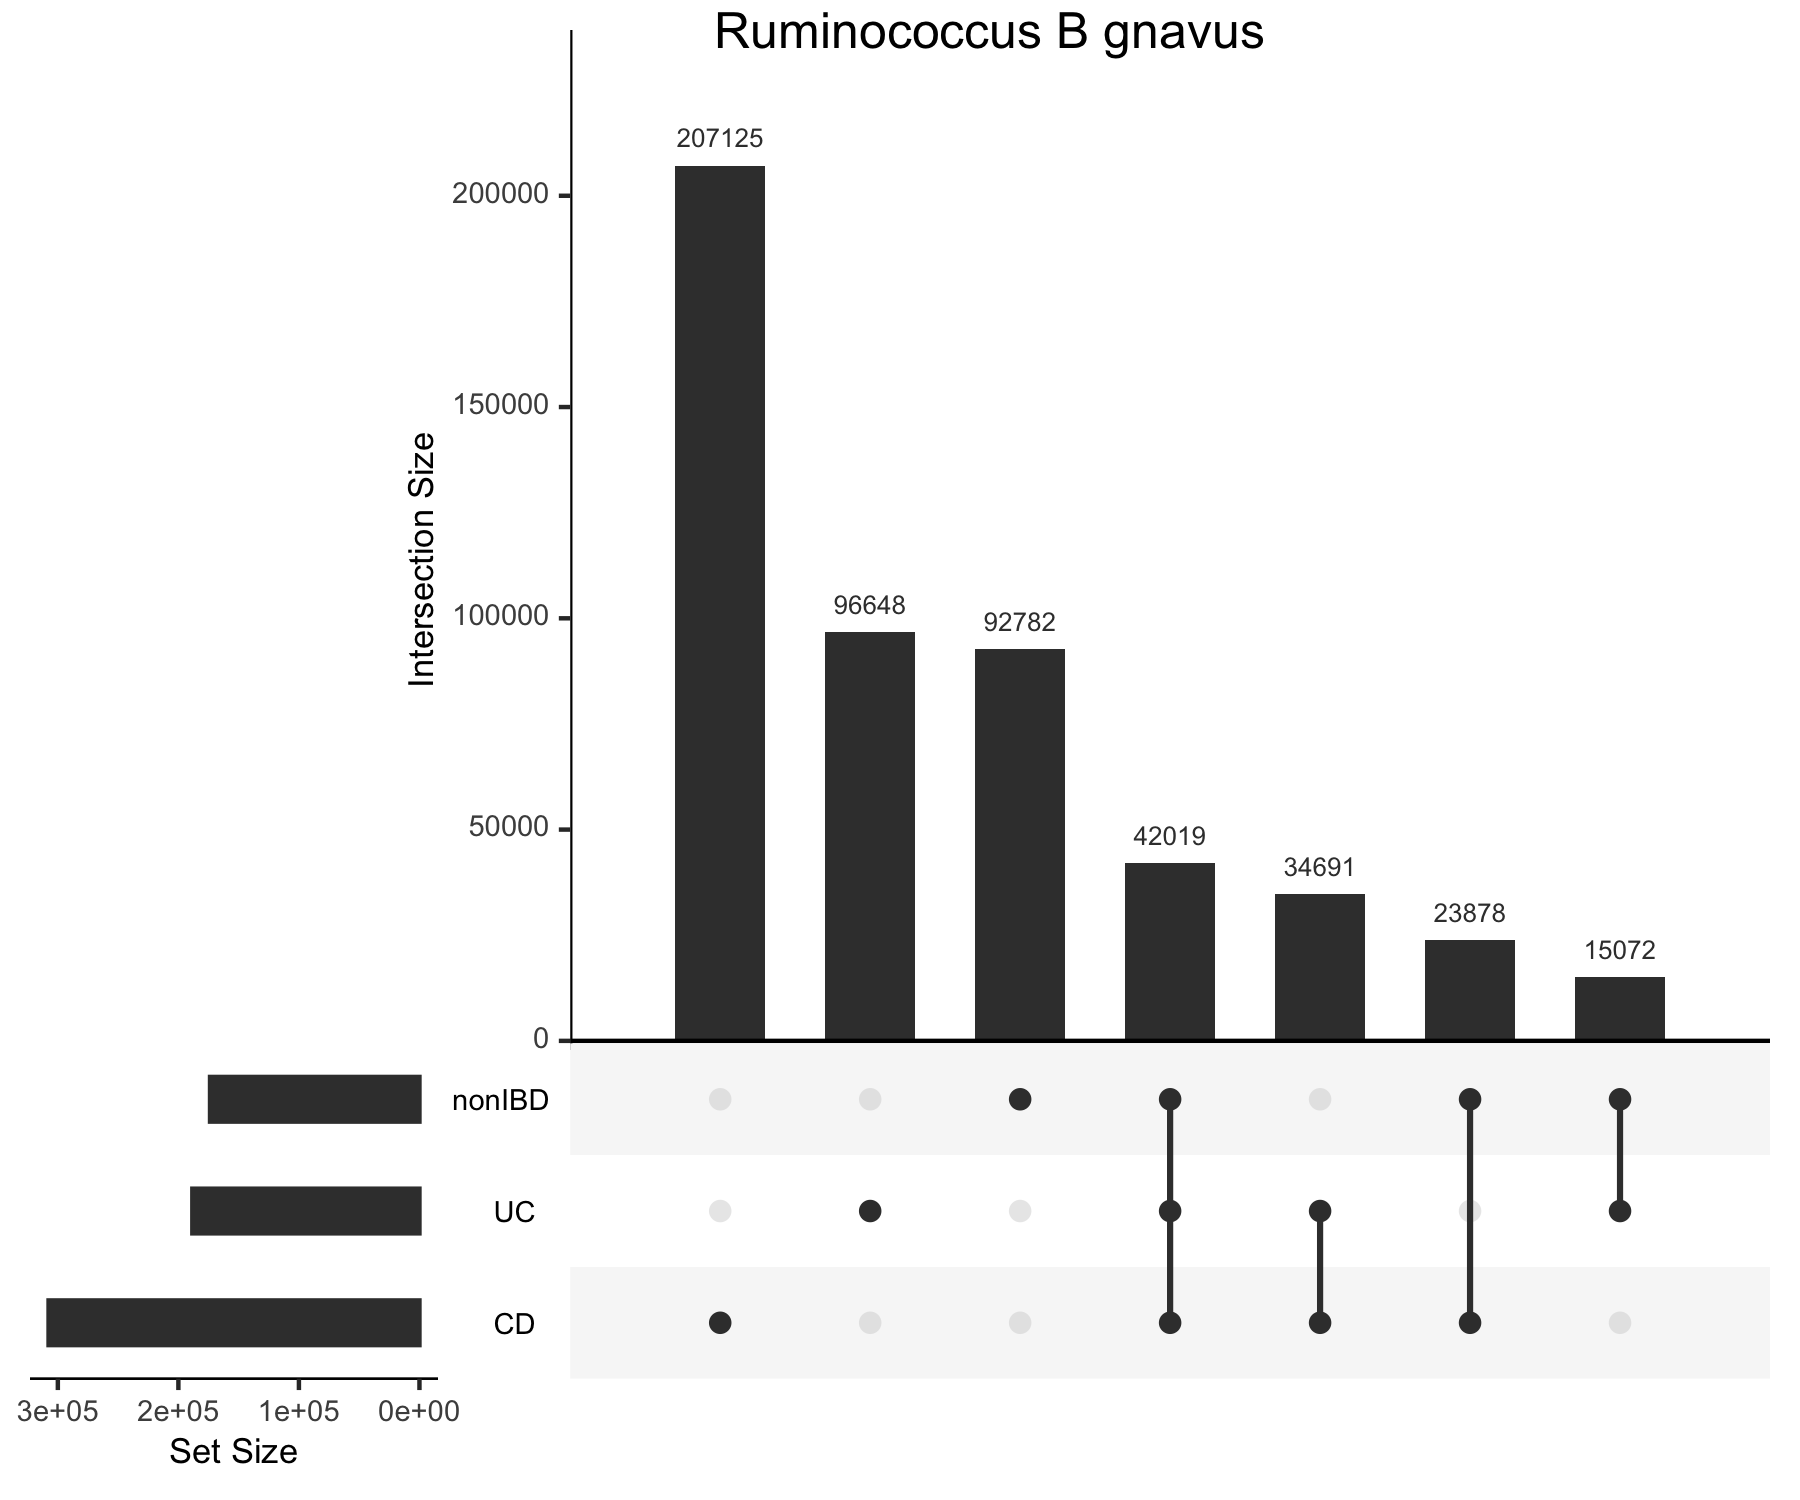

In [15]:
# adjust plot size rendered inline
options(repr.plot.width =6, repr.plot.height = 5, repr.plot.res = 300)

# how many hashes are shared for each diagnosis?
uc <- filter(sketch_table, diagnosis == "UC")$minhash
cd <- filter(sketch_table, diagnosis == "CD")$minhash
nonibd <- filter(sketch_table, diagnosis == "nonIBD")$minhash
upset_list <- list(UC = uc, CD = cd, nonIBD = nonibd)
upset_df <- fromList(upset_list)
upset(upset_df, order.by = "freq")
grid::grid.text(species_string3, x = 0.55, y=0.98, gp=grid::gpar(fontsize=12))

### report intersection sizes as a dataframe

In [16]:
overlapGroups <- function (listInput, sort = TRUE) {
  # listInput could look like this:
  # $one
  # [1] "a" "b" "c" "e" "g" "h" "k" "l" "m"
  # $two
  # [1] "a" "b" "d" "e" "j"
  # $three
  # [1] "a" "e" "f" "g" "h" "i" "j" "l" "m"
  listInputmat    <- fromList(listInput) == 1
  #     one   two three
  # a  TRUE  TRUE  TRUE
  # b  TRUE  TRUE FALSE
  #...
  # condensing matrix to unique combinations elements
  listInputunique <- unique(listInputmat)
  grouplist <- list()
  # going through all unique combinations and collect elements for each in a list
  for (i in 1:nrow(listInputunique)) {
    currentRow <- listInputunique[i,]
    myelements <- which(apply(listInputmat,1,function(x) all(x == currentRow)))
    attr(myelements, "groups") <- currentRow
    grouplist[[paste(colnames(listInputunique)[currentRow], collapse = "_")]] <- myelements
    myelements
    # attr(,"groups")
    #   one   two three 
    # FALSE FALSE  TRUE 
    #  f  i 
    # 12 13 
  }
  if (sort) {
    grouplist <- grouplist[order(sapply(grouplist, function(x) length(x)), decreasing = TRUE)]
  }
  attr(grouplist, "elements") <- unique(unlist(listInput))
  return(grouplist)
  # save element list to facilitate access using an index in case rownames are not named
}

In [17]:
li <- overlapGroups(upset_list)

In [18]:
li2 <- purrr::map(li, ~ attr(li, "elements")[.x] )
set_sizes <- sapply(li2, length)
data.frame(intersection = names(set_sizes),
           intersection_size = set_sizes) %>%
  mutate(species = species_string1) %>%
  pivot_wider(id_cols = species, names_from = intersection, values_from = intersection_size)

species,CD,UC,nonIBD,UC_CD_nonIBD,UC_CD,CD_nonIBD,UC_nonIBD
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GCF_008121495.1--s__Ruminococcus_B_gnavus,207125,96648,92782,42019,34691,23878,15072
